In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Load dataset
df = pd.read_csv('Q2-Dataset.csv')
print(f"\nOriginal dataset shape: {df.shape}")

# Create labels based on sample grouping (from visual analysis)
# Class 1 (North Italy): samples 0-149
# Class 2 (South Italy): samples 150-299
# Class 3 (Sardinia): samples 300-449
# Class 4 (Other regions): samples 450-569

labels = np.zeros(len(df), dtype=int)
labels[0:150] = 0      # North Italy
labels[150:300] = 1    # South Italy
labels[300:450] = 2    # Sardinia
labels[450:570] = 3    # Other regions

print(f"\nClass distribution:")
unique, counts = np.unique(labels, return_counts=True)
for cls, count in zip(unique, counts):
    region_names = ['North Italy', 'South Italy', 'Sardinia', 'Other Regions']
    print(f"  Class {cls} ({region_names[cls]}): {count} samples")

# Separate features and labels
X = df.values
y = labels

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Feature normalization (StandardScaler)
print("Feature Normalization")
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print(f"Before normalization - Mean: {X.mean():.6f}, Std: {X.std():.6f}")
print(f"After normalization  - Mean: {X_normalized.mean():.6f}, Std: {X_normalized.std():.6f}")

# One-hot encoding for labels
print("One-Hot Encoding")

from sklearn.preprocessing import OneHotEncoder

# Reshape y for one-hot encoding
y_reshaped = y.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y_reshaped)

print(f"Original labels shape: {y.shape}")
print(f"One-hot encoded labels shape: {y_onehot.shape}")
print(f"\nExample - First sample:")
print(f"  Original label: {y[0]} (North Italy)")
print(f"  One-hot encoded: {y_onehot[0]}")

# Split into train and test sets
print("Train/Test Split")
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_onehot, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Original dataset shape: (570, 60)

Class distribution:
  Class 0 (North Italy): 150 samples
  Class 1 (South Italy): 150 samples
  Class 2 (Sardinia): 150 samples
  Class 3 (Other Regions): 120 samples

Features shape: (570, 60)
Labels shape: (570,)
Feature Normalization
Before normalization - Mean: 0.333696, Std: 0.334330
After normalization  - Mean: 0.000000, Std: 1.000000
One-Hot Encoding
Original labels shape: (570,)
One-hot encoded labels shape: (570, 4)

Example - First sample:
  Original label: 0 (North Italy)
  One-hot encoded: [1. 0. 0. 0.]
Train/Test Split
Training set: 456 samples
Test set: 114 samples


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Custom RBF Layer in PyTorch
class RBFLayer(nn.Module):

    def __init__(self, in_features, out_features, gamma=1.0):
        
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.gamma = gamma
        
        # Initialize centers randomly - will be learned
        self.centers = nn.Parameter(
            torch.randn(out_features, in_features)
        )
    
    def forward(self, x):

        # x shape: (batch_size, in_features)
        # centers shape: (out_features, in_features)
        
        # Expand dimensions for broadcasting
        x_expanded = x.unsqueeze(1)  # (batch_size, 1, in_features)
        centers_expanded = self.centers.unsqueeze(0)  # (1, out_features, in_features)
        
        # Euclidean distance squared
        distances_sq = torch.sum((x_expanded - centers_expanded) ** 2, dim=-1)
        
        # Gaussian RBF activation
        rbf_output = torch.exp(-self.gamma * distances_sq)
        
        return rbf_output


n_centers = 40  # Appropriate for 4 classes
n_features = X_train.shape[1]
n_classes = 4

print(f"Number of training samples: {len(X_train)}")
print(f"Number of input features: {n_features}")
print(f"Number of classes: {n_classes}")
print(f"Selected number of RBF centers: {n_centers}")
print(f"RBF width parameter (gamma): 0.5")

# Create Sequential model with RBF layer
class RBFNetwork(nn.Module):
    def __init__(self, in_features, n_centers, n_classes, gamma=0.5):
        super(RBFNetwork, self).__init__()
        self.rbf_layer = RBFLayer(in_features, n_centers, gamma)
        self.output_layer = nn.Linear(n_centers, n_classes)
        
    def forward(self, x):
        x = self.rbf_layer(x)
        x = self.output_layer(x)
        return x

# Initialize model
model = RBFNetwork(
    in_features=n_features,
    n_centers=n_centers,
    n_classes=n_classes,
    gamma=0.5
)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


print("\nModel Architecture Details")

print(f"Input shape: ({n_features},) - {n_features} features")
print(f"RBF Layer: {n_centers} neurons (centers)")
print(f"Output Layer: {n_classes} neurons (one per class)")
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


print("Setting up Training")
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nModel setup completed successfully:")
print(f"  - Optimizer: Adam (lr=0.001)")
print(f"  - Loss: CrossEntropyLoss")
print(f"  - Batch size: 32")

Number of training samples: 456
Number of input features: 60
Number of classes: 4
Selected number of RBF centers: 40
RBF width parameter (gamma): 0.5
RBFNetwork(
  (rbf_layer): RBFLayer()
  (output_layer): Linear(in_features=40, out_features=4, bias=True)
)

Model Architecture Details
Input shape: (60,) - 60 features
RBF Layer: 40 neurons (centers)
Output Layer: 4 neurons (one per class)
Total parameters: 2564
Trainable parameters: 2564
Setting up Training

Model setup completed successfully:
  - Optimizer: Adam (lr=0.001)
  - Loss: CrossEntropyLoss
  - Batch size: 32


In [64]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import time

n_centers = 40      # number of RBF neurons
n_classes = 4
n_features = X_train.shape[1]

# ----- RBF layer with random centers -----
class RBFLayerRandom(nn.Module):
    def __init__(self, in_features, out_features, gamma=0.5):
        super(RBFLayerRandom, self).__init__()
        self.gamma = gamma
        # random centers ~ N(0, 1)
        self.centers = nn.Parameter(torch.randn(out_features, in_features))
    
    def forward(self, x):
        # x: (batch, in_features)
        x_exp = x.unsqueeze(1)               # (batch, 1, in_features)
        c_exp = self.centers.unsqueeze(0)    # (1, out_features, in_features)
        dist_sq = torch.sum((x_exp - c_exp) ** 2, dim=-1)
        return torch.exp(-self.gamma * dist_sq)

class RBFNetworkRandom(nn.Module):
    def __init__(self, in_features, n_centers, n_classes, gamma=0.5):
        super(RBFNetworkRandom, self).__init__()
        self.rbf = RBFLayerRandom(in_features, n_centers, gamma)
        self.out = nn.Linear(n_centers, n_classes)
    
    def forward(self, x):
        x = self.rbf(x)
        x = self.out(x)
        return x

# ----- build model -----
model = RBFNetworkRandom(n_features, n_centers, n_classes, gamma=0.5)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

# ----- data tensors -----
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(np.argmax(y_train, axis=1))
X_test_tensor  = torch.FloatTensor(X_test)
y_test_tensor  = torch.LongTensor(np.argmax(y_test, axis=1))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----- training setup -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs  = 100
print_every = 10

print("\nTraining RBF (random centers)...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        loss    = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        total   += batch_y.size(0)
        correct += (preds == batch_y).sum().item()
        epoch_loss += loss.item()
    
    if (epoch + 1) % print_every == 0:
        avg_loss = epoch_loss / len(train_loader)
        acc      = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")


print(f"Training finished in {time.time() - start_time:.2f} seconds")

# ----- evaluation -----
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    test_acc = accuracy_score(y_test_tensor, test_preds)

print("\nTest Accuracy (RBF random centers): {:.2f}%".format(test_acc * 100))
print("Test Samples:", len(X_test_tensor))

target_names = ['North Italy', 'South Italy', 'Sardinia', 'Other Regions']
print("\nClassification Report:")
print(classification_report(y_test_tensor, test_preds, target_names=target_names, digits=4, zero_division=0))

RBFNetworkRandom(
  (rbf): RBFLayerRandom()
  (out): Linear(in_features=40, out_features=4, bias=True)
)
Total parameters: 2564

Training RBF (random centers)...
Epoch [10/100] - Loss: 1.3878, Accuracy: 26.32%
Epoch [20/100] - Loss: 1.3829, Accuracy: 26.32%
Epoch [30/100] - Loss: 1.3840, Accuracy: 26.32%
Epoch [40/100] - Loss: 1.3827, Accuracy: 26.32%
Epoch [50/100] - Loss: 1.3850, Accuracy: 26.32%
Epoch [60/100] - Loss: 1.3811, Accuracy: 26.32%
Epoch [70/100] - Loss: 1.3810, Accuracy: 26.32%
Epoch [80/100] - Loss: 1.3797, Accuracy: 26.32%
Epoch [90/100] - Loss: 1.3825, Accuracy: 26.32%
Epoch [100/100] - Loss: 1.3840, Accuracy: 26.32%
Training finished in 3.48 seconds

Test Accuracy (RBF random centers): 26.32%
Test Samples: 114

Classification Report:
               precision    recall  f1-score   support

  North Italy     0.0000    0.0000    0.0000        30
  South Italy     0.0000    0.0000    0.0000        30
     Sardinia     0.2632    1.0000    0.4167        30
Other Regions   

In [65]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import pdist
import time

print("PART C: Model Training and Accuracy Evaluation")
# Step 1: Initialize RBF centers using KMeans
n_centers = 80
print(f"\nStep 1: Finding {n_centers} centers using KMeans...")

kmeans = KMeans(n_clusters=n_centers, random_state=42, n_init=10)
kmeans.fit(X_train)
centers_np = kmeans.cluster_centers_
centers_tensor = torch.FloatTensor(centers_np)

# Compute gamma
dists = pdist(centers_np)
mean_dist = dists.mean()
sigma = mean_dist
gamma = 1.0 / (2.0 * sigma**2)

print(f"KMeans completed: {n_centers} centers found")
print(f"Mean distance between centers: {mean_dist:.4f}")
print(f"Sigma: {sigma:.4f}")
print(f"Gamma: {gamma:.6f}")


# Step 2: Define RBF Network
print("Step 2: Building RBF Network")
class RBFLayer(nn.Module):

    def __init__(self, centers, gamma):
        super(RBFLayer, self).__init__()
        self.gamma = gamma
        self.register_buffer('centers', centers.clone())
    
    def forward(self, x):
        # Compute Gaussian RBF: exp(-gamma * ||x - c||^2)
        x_exp = x.unsqueeze(1)              # (batch, 1, features)
        c_exp = self.centers.unsqueeze(0)   # (1, n_centers, features)
        dist_sq = torch.sum((x_exp - c_exp) ** 2, dim=-1)
        return torch.exp(-self.gamma * dist_sq)


class RBFNetwork(nn.Module):

    def __init__(self, centers, gamma, n_classes=4):
        super(RBFNetwork, self).__init__()
        self.rbf = RBFLayer(centers, gamma)
        self.output = nn.Linear(centers.shape[0], n_classes)
    
    def forward(self, x):
        x = self.rbf(x)
        x = self.output(x)
        return x


n_classes = 4
model = RBFNetwork(centers_tensor, gamma, n_classes=n_classes)
total_params = sum(p.numel() for p in model.parameters())

print(f"RBF Network created:")
print(f"  - Input features: {X_train.shape[1]}")
print(f"  - RBF centers: {n_centers}")
print(f"  - Output classes: {n_classes}")
print(f"  - Total parameters: {total_params}")


# Step 3: Prepare data and training setup
print("Step 3: Preparing Data and Training Setup")
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(np.argmax(y_train, axis=1))
X_test_tensor  = torch.FloatTensor(X_test)
y_test_tensor  = torch.LongTensor(np.argmax(y_test, axis=1))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Training samples: {len(X_train_tensor)}")
print(f"Test samples: {len(X_test_tensor)}")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: CrossEntropyLoss")
print(f"Batch size: 32")


# Step 4: Train the model
print("Step 4: Training RBF Network")
num_epochs = 100
print_every = 10
train_losses = []
train_accuracies = []

torch.manual_seed(42)
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_x, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (preds == batch_y).sum().item()
        epoch_loss += loss.item()
    
    # Store training history
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")


# Step 5: Evaluate on test set
print("Step 5: Test Set Evaluation")
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test_tensor, test_preds)

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Samples: {len(X_test_tensor)}")

print("\nDetailed Classification Report:")
target_names = ['North Italy', 'South Italy', 'Sardinia', 'Other Regions']
print(classification_report(y_test_tensor, test_preds, 
                            target_names=target_names, digits=4, zero_division=0))

PART C: Model Training and Accuracy Evaluation

Step 1: Finding 80 centers using KMeans...
KMeans completed: 80 centers found
Mean distance between centers: 11.6009
Sigma: 11.6009
Gamma: 0.003715
Step 2: Building RBF Network
RBF Network created:
  - Input features: 60
  - RBF centers: 80
  - Output classes: 4
  - Total parameters: 324
Step 3: Preparing Data and Training Setup
Training samples: 456
Test samples: 114
Optimizer: Adam (lr=0.001)
Loss function: CrossEntropyLoss
Batch size: 32
Step 4: Training RBF Network
Epoch [10/100] - Loss: 1.1325, Accuracy: 57.24%
Epoch [20/100] - Loss: 1.0929, Accuracy: 58.11%
Epoch [30/100] - Loss: 1.0604, Accuracy: 56.36%
Epoch [40/100] - Loss: 1.0587, Accuracy: 55.04%
Epoch [50/100] - Loss: 1.0311, Accuracy: 58.11%
Epoch [60/100] - Loss: 1.0571, Accuracy: 58.11%
Epoch [70/100] - Loss: 1.0310, Accuracy: 56.14%
Epoch [80/100] - Loss: 1.0304, Accuracy: 57.46%
Epoch [90/100] - Loss: 1.0218, Accuracy: 58.55%
Epoch [100/100] - Loss: 1.0062, Accuracy: 57.0

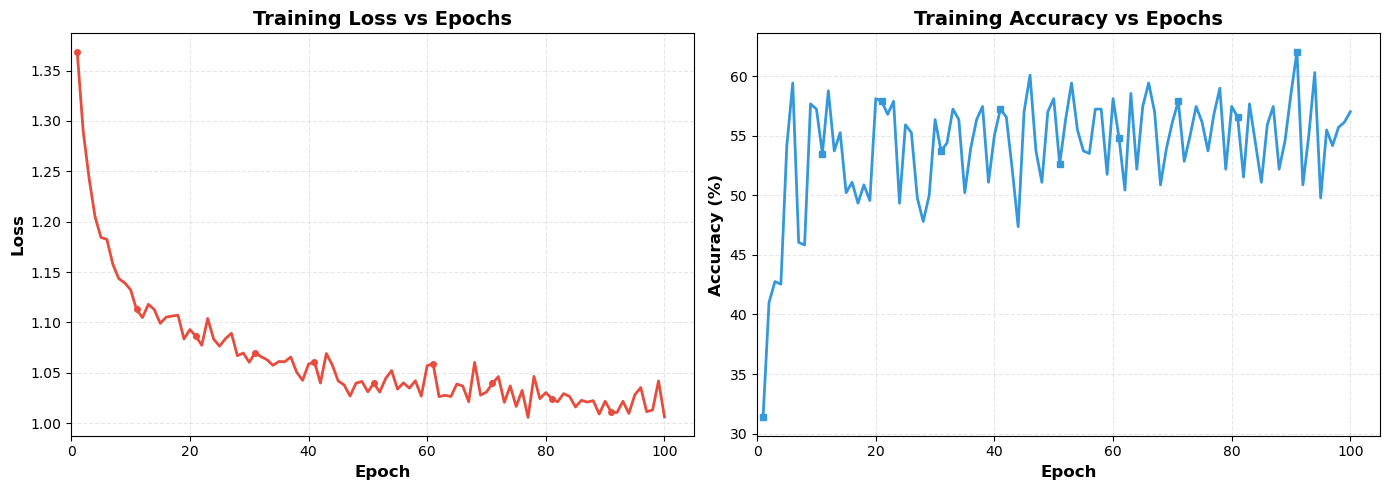

Initial Loss: 1.3689
Final Loss: 1.0062
Loss Reduction: 0.3626

Initial Accuracy: 31.36%
Final Accuracy: 57.02%
Best Accuracy: 62.06% (at epoch 91)


In [75]:
import matplotlib.pyplot as plt
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss over Epochs
ax1.plot(range(1, len(train_losses) + 1), train_losses, 
         linewidth=2, color='#e74c3c', marker='o', 
         markevery=10, markersize=4)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss vs Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(0, len(train_losses) + 5)

# Plot 2: Training Accuracy over Epochs
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, 
         linewidth=2, color='#3498db', marker='s', 
         markevery=10, markersize=4)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training Accuracy vs Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(0, len(train_accuracies) + 5)

# Adjust layout and display
plt.tight_layout()
plt.savefig('RBF_Training_History.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Loss Reduction: {train_losses[0] - train_losses[-1]:.4f}")
print(f"\nInitial Accuracy: {train_accuracies[0]:.2f}%")
print(f"Final Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Best Accuracy: {max(train_accuracies):.2f}% (at epoch {train_accuracies.index(max(train_accuracies)) + 1})")